In [3]:
# ============================
# MLBR end-to-end pipeline (MERIT-style, ablation-ready) with ESM2 integration
# ============================
import os, glob, random
from pathlib import Path
import numpy as np

try:
    from sklearn.metrics import roc_auc_score, average_precision_score
    HAVE_SK = True
except Exception:
    HAVE_SK = False

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ============================
# CONFIG (edit paths)
# ============================
BASE          = Path(r"/Users/bindusamba/Documents/protein_ligand")
TXT_PATH      = BASE / "train2684.txt"
FASTA_PATH    = BASE / "train2684.fasta"

ESM_DIR       = BASE / "features_esm"         # (L, D_esm) per PID
LABELS_DIR    = BASE / "labels"               # (L,)
SEQ45_DIR     = BASE / "extracted_features"   # (L,45)
EVO_DIR       = BASE / "features_evo"         # (L,20)
STRUCT_DIR    = BASE / "features_struct"      # (L,6)
PHYS_DIR      = BASE / "features_physchem"    # (L,10)
FINAL_DIR     = BASE / "features_final"       # (L, seq_w + 36)
CKPT_DIR      = BASE / "checkpoints"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

USE_SEQ_ONEHOT_FALLBACK = False

SEED          = 42
BATCH_SIZE    = 16
EPOCHS        = 100
LR            = 3e-4
WEIGHT_DECAY  = 1e-4
VAL_FRAC      = 0.10
TEST_FRAC     = 0.10
MAX_LEN       = 670
POS_WEIGHT_FALLBACK = 10.0
USE_FOCAL     = False
FOCAL_ALPHA   = 0.25
FOCAL_GAMMA   = 2.0

# ============================
# Utils & IO
# ============================
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

AA = "ACDEFGHIKLMNPQRSTVWY"
AA_IDX = {a:i for i,a in enumerate(AA)}

def read_fasta(path: Path):
    with open(path, "r", encoding="utf-8") as f:
        pid, chunks = None, []
        for line in f:
            line = line.strip()
            if not line: continue
            if line.startswith(">"):
                if pid is not None:
                    yield pid, "".join(chunks)
                pid = line[1:].split()[0]
                chunks = []
            else:
                chunks.append(line)
        if pid is not None:
            yield pid, "".join(chunks)

def write_fasta_from_txt(txt_path: Path, fasta_path: Path):
    fasta_path.parent.mkdir(parents=True, exist_ok=True)
    with open(txt_path, "r", encoding="utf-8") as infile, open(fasta_path, "w", encoding="utf-8") as out:
        lines = [ln.rstrip("\n") for ln in infile]
        for i in range(0, len(lines), 4):
            if i + 1 >= len(lines): break
            if lines[i].startswith(">"):
                out.write(f"{lines[i].strip()}\n{lines[i+1].strip()}\n")
    print(f"[STEP] FASTA written: {fasta_path}")

def blocks_from_txt(txt_path: Path):
    with open(txt_path, "r", encoding="utf-8") as f:
        lines = [ln.rstrip("\n") for ln in f if ln.strip()!=""]
    i = 0
    while i < len(lines):
        if not lines[i].startswith(">"):
            i += 1; continue
        pid = lines[i][1:].strip()
        seq = lines[i+1].strip()
        third = lines[i+2].strip() if i+2 < len(lines) else ""
        fourth= lines[i+3].strip() if i+3 < len(lines) else ""

        is_label = lambda s: len(s)==len(seq) and all(ch in ".SMX" for ch in s)
        if is_label(third) and not is_label(fourth):
            labels, step = third, 3
        elif not is_label(third) and is_label(fourth):
            labels, step = fourth, 4
        elif is_label(third) and is_label(fourth):
            score = lambda s: sum(ch in ".SM" for ch in s)
            labels = third if score(third) >= score(fourth) else fourth
            step = 4
        else:
            raise ValueError(f"Cannot detect label line for {pid}")
        yield pid, seq, labels
        i += step

def build_labels(txt_path: Path, out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)
    n=0
    for pid, seq, lab in blocks_from_txt(txt_path):
        assert len(seq)==len(lab)
        y = np.fromiter((1.0 if ch=='M' else 0.0 for ch in lab), dtype=np.float32, count=len(lab))
        np.save(out_dir / f"{pid}.npy", y); n += 1
    print(f"[STEP] labels: wrote {n} arrays to {out_dir}")

def one_hot_encode(seq: str):
    X = np.zeros((len(seq), 20), dtype=np.float32)
    for i, aa in enumerate(seq):
        j = AA_IDX.get(aa)
        if j is not None: X[i,j] = 1.0
    return X

def seq45_available():
    return len(glob.glob(str(SEQ45_DIR / "*.npy"))) > 0

def esm_available_for_any(fasta_path: Path):
    for pid,_ in read_fasta(fasta_path):
        if (ESM_DIR / f"{pid}.npy").exists():
            return True
    return False

def fasta_ids_in_order(fasta_path: Path):
    return [pid for pid,_ in read_fasta(fasta_path)]

def detect_seq_width_global(fasta_path: Path):
    """Decide dataset-wide sequence width: prefer ESM -> 45 -> 20 (fallback) -> 45(stub)."""
    ids = fasta_ids_in_order(fasta_path)
    # Prefer ESM
    for pid in ids:
        f = ESM_DIR / f"{pid}.npy"
        if f.exists():
            try:
                d = np.load(f, mmap_mode="r").shape[1]
                return d, "ESM"
            except Exception:
                pass
    if seq45_available():
        return 45, "SEQ45"
    if USE_SEQ_ONEHOT_FALLBACK:
        return 20, "ONEHOT"
    return 45, "STUB"

# ---------- Evo/Struct/Phys stubs ----------
def step_22_evo_features(fasta_path: Path, evo_dir: Path):
    evo_dir.mkdir(parents=True, exist_ok=True)
    pairs = list(read_fasta(fasta_path))
    print(f"[Step 2.2] Building evolutionary features for {len(pairs)} proteins…")
    for pid, seq in pairs:
        out = evo_dir / f"{pid}.npy"
        if out.exists(): continue
        print(f"  [hint] {pid} (L={len(seq)}): run HHblits/PSI-BLAST; save {out.name} (L,20)")
        np.save(out, np.zeros((len(seq), 20), dtype=np.float32))
    print("[Step 2.2] Done (stubs for missing files).")

def step_23_struct_features(fasta_path: Path, struct_dir: Path):
    struct_dir.mkdir(parents=True, exist_ok=True)
    pairs = list(read_fasta(fasta_path))
    print(f"[Step 2.3] Building structural features for {len(pairs)} proteins…")
    for pid, seq in pairs:
        out = struct_dir / f"{pid}.npy"
        if out.exists(): continue
        print(f"  [hint] {pid}: run PSIPRED/SPIDER3; save {out.name} (L,6) [pH,pE,pC,ASA,phi,psi]")
        np.save(out, np.zeros((len(seq), 6), dtype=np.float32))
    print("[Step 2.3] Done (stubs for missing files).")

KD = {'A':1.8,'C':2.5,'D':-3.5,'E':-3.5,'F':2.8,'G':-0.4,'H':-3.2,'I':4.5,'K':-3.9,'L':3.8,'M':1.9,'N':-3.5,'P':-1.6,'Q':-3.5,'R':-4.5,'S':-0.8,'T':-0.7,'V':4.2,'W':-0.9,'Y':-1.3}
POL= {'A':8.1,'C':5.5,'D':13.0,'E':12.3,'F':5.2,'G':9.0,'H':10.4,'I':5.2,'K':11.3,'L':4.9,'M':5.7,'N':11.6,'P':8.0,'Q':10.5,'R':10.5,'S':9.2,'T':8.6,'V':5.9,'W':5.4,'Y':6.2}
VOL= {'A':88.6,'C':108.5,'D':111.1,'E':138.4,'F':189.9,'G':60.1,'H':153.2,'I':166.7,'K':168.6,'L':166.7,'M':162.9,'N':114.1,'P':112.7,'Q':143.8,'R':173.4,'S':89.0,'T':116.1,'V':140.0,'W':227.8,'Y':193.6}
AROM = {a: float(a in "FWYH") for a in AA}
POSQ = {a: float(a in "KRH") for a in AA}
NEGG = {a: float(a in "DE") for a in AA}
HBD  = {a: float(a in "NQSTYHWKR") for a in AA}
HBA  = {a: float(a in "DEQNSTYH") for a in AA}
FLEX = {a: (200 - VOL[a]) / 200.0 for a in AA}
HELX = {'A':1.45,'C':0.77,'D':1.01,'E':1.51,'F':1.13,'G':0.53,'H':1.00,'I':1.08,'K':1.16,'L':1.34,'M':1.20,'N':0.67,'P':0.59,'Q':1.11,'R':0.79,'S':0.79,'T':0.82,'V':1.06,'W':1.14,'Y':0.61}

def physchem_for_sequence(seq):
    L = len(seq)
    X = np.zeros((L, 10), dtype=np.float32)
    for i, aa in enumerate(seq):
        if aa not in AA_IDX: continue
        X[i,0]=KD[aa]; X[i,1]=POL[aa]; X[i,2]=VOL[aa]; X[i,3]=AROM[aa]; X[i,4]=POSQ[aa]
        X[i,5]=NEGG[aa]; X[i,6]=HBD[aa]; X[i,7]=HBA[aa]; X[i,8]=FLEX[aa]; X[i,9]=HELX[aa]
    X = (X - X.mean(0, keepdims=True)) / (X.std(0, keepdims=True) + 1e-6)
    return X

def step_24_physchem_features(fasta_path: Path, phys_dir: Path):
    phys_dir.mkdir(parents=True, exist_ok=True)
    pairs = list(read_fasta(fasta_path))
    print(f"[Step 2.4] Building physicochemical features for {len(pairs)} proteins…")
    for pid, seq in pairs:
        out = phys_dir / f"{pid}.npy"
        if out.exists(): continue
        np.save(out, physchem_for_sequence(seq))
    print("[Step 2.4] Done.")

# ============================
# Step 2.5: Concatenate with GLOBAL seq width (ESM-aware)
# ============================
def step_25_concatenate(fasta_path: Path):
    FINAL_DIR.mkdir(parents=True, exist_ok=True)
    pairs = list(read_fasta(fasta_path))
    print(f"[Step 2.5] Concatenating features for {len(pairs)} proteins…")

    seq_w_global, seq_src = detect_seq_width_global(fasta_path)
    print(f"[INFO] Sequence block source={seq_src}  width={seq_w_global}")

    if seq_src == "ESM":
        have_esm = sum((ESM_DIR / f"{pid}.npy").exists() for pid,_ in pairs)
        print(f"[INFO] ESM present for {have_esm}/{len(pairs)} proteins")

    for pid, seq in pairs:
        L = len(seq)
        out = FINAL_DIR / f"{pid}.npy"
        if out.exists(): 
            continue

        # --- Sequence block to EXACTLY seq_w_global ---
        if seq_src == "ESM":
            f = ESM_DIR / f"{pid}.npy"
            if f.exists():
                arr = np.load(f)
                if arr.shape[0] != L:
                    if arr.shape[0] > L: arr = arr[:L]
                    else:
                        pad = np.zeros((L - arr.shape[0], arr.shape[1]), dtype=arr.dtype)
                        arr = np.vstack([arr, pad])
                D = arr.shape[1]
                if D == seq_w_global:
                    seq_block = arr.astype(np.float32)
                elif D > seq_w_global:
                    seq_block = arr[:, :seq_w_global].astype(np.float32)
                else:
                    pad = np.zeros((L, seq_w_global - D), dtype=np.float32)
                    seq_block = np.hstack([arr.astype(np.float32), pad])
            else:
                seq_block = np.zeros((L, seq_w_global), dtype=np.float32)

        elif seq_src == "SEQ45":
            p45 = SEQ45_DIR / f"{pid}.npy"
            if p45.exists():
                arr = np.load(p45)
                if arr.shape[0] != L:
                    if arr.shape[0] > L: arr = arr[:L]
                    else:
                        pad = np.zeros((L - arr.shape[0], arr.shape[1]), dtype=arr.dtype)
                        arr = np.vstack([arr, pad])
                seq_block = arr.astype(np.float32)
            else:
                seq_block = np.zeros((L, 45), dtype=np.float32)

        elif seq_src == "ONEHOT":
            seq_block = one_hot_encode(seq)

        else:  # STUB
            seq_block = np.zeros((L, 45), dtype=np.float32)

        # --- Other blocks (fixed widths) ---
        evo_path = EVO_DIR / f"{pid}.npy"
        evo_block = np.load(evo_path) if evo_path.exists() else np.zeros((L,20), dtype=np.float32)

        struct_path = STRUCT_DIR / f"{pid}.npy"
        struct_block = np.load(struct_path) if struct_path.exists() else np.zeros((L,6), dtype=np.float32)

        phys_path = PHYS_DIR / f"{pid}.npy"
        phys_block = np.load(phys_path) if phys_path.exists() else np.zeros((L,10), dtype=np.float32)

        # Align lengths
        def fix_len(arr, D):
            if arr.shape[0] == L: return arr
            if arr.shape[0] > L:  return arr[:L]
            pad = np.zeros((L - arr.shape[0], D), dtype=arr.dtype)
            return np.vstack([arr, pad])

        seq_block    = fix_len(seq_block,    seq_block.shape[1])
        evo_block    = fix_len(evo_block,    20)
        struct_block = fix_len(struct_block, 6)
        phys_block   = fix_len(phys_block,   10)

        X = np.concatenate([seq_block, evo_block, struct_block, phys_block], axis=1)
        np.save(out, X)

    print("[Step 2.5] Done.")

# ============================
# Dataset, Collate, Model
# ============================
class ConcatFeatureDataset(Dataset):
    def __init__(self, ids, final_dir: Path, labels_dir: Path, feat_slice=None):
        self.ids = list(ids)
        self.final_dir = Path(final_dir)
        self.labels_dir= Path(labels_dir)
        self.feat_slice= feat_slice

    def __len__(self): return len(self.ids)

    def __getitem__(self, idx):
        pid = self.ids[idx]
        X = np.load(self.final_dir / f"{pid}.npy")
        y = np.load(self.labels_dir / f"{pid}.npy").astype(np.float32)
        assert X.shape[0] == y.shape[0], f"len mismatch {pid}"
        if self.feat_slice is not None: X = X[:, self.feat_slice]
        m = np.ones_like(y, dtype=np.float32)
        return pid, torch.tensor(X, dtype=torch.float32), torch.tensor(y), torch.tensor(m)

def pad_and_stack(batch, max_len=MAX_LEN):
    pids, xs, ys, ms = zip(*batch)
    F = xs[0].shape[1]
    B = len(xs)
    Xpad = torch.zeros(B, max_len, F)
    Ypad = torch.zeros(B, max_len)
    Mpad = torch.zeros(B, max_len)
    for i,(x,y,m) in enumerate(zip(xs,ys,ms)):
        L = min(x.shape[0], max_len)
        Xpad[i,:L] = x[:L]; Ypad[i,:L] = y[:L]; Mpad[i,:L] = m[:L]
    return pids, Xpad, Ypad, Mpad

class ResidueCNNDilated(nn.Module):
    def __init__(self, in_ch, channels=(64,128,128), kernel=7, dilations=(1,2,4), p_drop=0.3):
        super().__init__()
        layers=[]; cprev=in_ch
        for c,d in zip(channels, dilations):
            pad = (kernel//2)*d
            layers += [
                nn.Conv1d(cprev, c, kernel_size=kernel, padding=pad, dilation=d),
                nn.BatchNorm1d(c), nn.ReLU(inplace=True), nn.Dropout(p_drop),
            ]
            cprev = c
        self.backbone = nn.Sequential(*layers)
        self.head = nn.Conv1d(cprev, 1, kernel_size=1)
    def forward(self, x):
        x = x.transpose(1,2)               # (B, F, L)
        h = self.backbone(x)
        return self.head(h).squeeze(1)     # (B, L)

# ============================
# Losses & Metrics (with sensitivity)
# ============================
def bce_masked(logits, y, m, pos_weight=1.0):
    pw = torch.tensor(pos_weight, device=logits.device) if not isinstance(pos_weight, torch.Tensor) else pos_weight
    loss = F.binary_cross_entropy_with_logits(logits, y, reduction="none", pos_weight=pw)
    return (loss * m).sum() / (m.sum().clamp_min(1.0))

def focal_masked(logits, y, m, alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA):
    p = torch.sigmoid(logits)
    ce = F.binary_cross_entropy_with_logits(logits, y, reduction="none")
    pt = p*y + (1-p)*(1-y)
    w  = alpha * (1-pt).pow(gamma)
    return (w * ce * m).sum() / (m.sum().clamp_min(1.0))

@torch.no_grad()
def best_threshold_on_val(model, loader, device):
    model.eval()
    all_p, all_y, all_m = [], [], []
    for _, X, Y, M in loader:
        X = X.to(device); Y = Y.to(device); M = M.to(device)
        P = torch.sigmoid(model(X)).detach().cpu().numpy()
        all_p.append(P); all_y.append(Y.cpu().numpy()); all_m.append(M.cpu().numpy())
    p = np.concatenate(all_p); y = np.concatenate(all_y); m = np.concatenate(all_m).astype(bool)

    best_t, best_f1 = 0.5, 0.0
    for t in np.linspace(0.05, 0.95, 19):
        pred = (p >= t).astype(int)
        TP = ((pred==1)&(y==1)&m).sum(); FP=((pred==1)&(y==0)&m).sum()
        FN = ((pred==0)&(y==1)&m).sum(); TN=((pred==0)&(y==0)&m).sum()
        prec = TP / max(1, TP+FP); rec = TP / max(1, TP+FN)
        f1 = 2*prec*rec / max(1e-9, prec+rec)
        if f1 > best_f1: best_f1, best_t = f1, t

    auc = np.nan; aupr = np.nan
    if HAVE_SK:
        try:
            auc  = roc_auc_score(y[m].ravel(),  p[m].ravel())
            aupr = average_precision_score(y[m].ravel(), p[m].ravel())
        except Exception:
            pass
    return best_t, best_f1, auc, aupr

@torch.no_grad()
def _sensitivity_at_equal_positives(p, y, m):
    m = m.astype(bool)
    pm = p[m].ravel(); ym = y[m].ravel().astype(int)
    n_pos = int(ym.sum())
    if n_pos <= 0 or pm.size == 0: return float('nan'), 0.5
    kth = np.partition(pm, pm.size - n_pos)[pm.size - n_pos]
    thr = float(kth)
    pred = (p >= thr).astype(int)
    TP = ((pred==1)&(y==1)&m).sum(); FN = ((pred==0)&(y==1)&m).sum()
    return TP / max(1, TP + FN), thr

@torch.no_grad()
def _sensitivity_at_fixed_fpr(p, y, m, target_fpr=0.05):
    m = m.astype(bool)
    pm = p[m].ravel(); ym = y[m].ravel().astype(int)
    if pm.size == 0: return float('nan'), 0.5, float('nan')
    thr_list = np.unique(pm); thr_list = np.concatenate([[-1e9], thr_list, [1e9]])
    n_neg = int((ym==0).sum()); 
    if n_neg == 0: return float('nan'), 0.5, float('nan')
    best = (None, None, None)
    for thr in thr_list:
        pred = (pm >= thr).astype(int)
        FP = int(((pred==1)&(ym==0)).sum())
        TP = int(((pred==1)&(ym==1)).sum())
        FN = int(((pred==0)&(ym==1)).sum())
        fpr = FP / n_neg
        sens = TP / max(1, TP + FN)
        delta = abs(fpr - target_fpr)
        if best[0] is None or delta < best[0]:
            best = (delta, sens, thr)
    _, sens_best, thr_best = best
    pred_full = (p >= thr_best).astype(int)
    FP = ((pred_full==1)&(y==0)&m).sum()
    TN = ((pred_full==0)&(y==0)&m).sum()
    fpr_best = FP / max(1, FP + TN)
    return sens_best, float(thr_best), float(fpr_best)

@torch.no_grad()
def test_metrics(model, loader, device, threshold):
    model.eval()
    all_p, all_y, all_m = [], [], []
    for _, X, Y, M in loader:
        X = X.to(device); Y = Y.to(device); M = M.to(device)
        P = torch.sigmoid(model(X)).detach().cpu().numpy()
        all_p.append(P); all_y.append(Y.cpu().numpy()); all_m.append(M.cpu().numpy())
    p = np.concatenate(all_p); y = np.concatenate(all_y); m = np.concatenate(all_m).astype(bool)

    pred = (p >= threshold).astype(int)
    TP = ((pred==1)&(y==1)&m).sum(); FP=((pred==1)&(y==0)&m).sum()
    FN = ((pred==0)&(y==1)&m).sum(); TN=((pred==0)&(y==0)&m).sum()
    acc = (TP+TN) / max(1, TP+TN+FP+FN)
    prec = TP / max(1, TP+FP); rec = TP / max(1, TP+FN)
    f1 = 2*prec*rec / max(1e-9, prec+rec)

    auc = np.nan; aupr = np.nan
    if HAVE_SK:
        try:
            auc  = roc_auc_score(y[m].ravel(),  p[m].ravel())
            aupr = average_precision_score(y[m].ravel(), p[m].ravel())
        except Exception:
            pass

    sens_eqpos, thr_eqpos = _sensitivity_at_equal_positives(p, y, m)
    sens_fpr5, thr_fpr5, fpr_seen = _sensitivity_at_fixed_fpr(p, y, m, target_fpr=0.05)

    return {
        "acc": acc, "auc": auc, "aupr": aupr, "f1": f1,
        "sens_basic_at_thr": rec, "thr_basic": float(threshold),
        "sens_at_equal_positives": sens_eqpos, "thr_eqpos": thr_eqpos,
        "sens_at_fpr5": sens_fpr5, "thr_fpr5": thr_fpr5, "achieved_fpr": fpr_seen
    }

def compute_pos_weight(ids, labels_dir: Path):
    pos=neg=0
    for pid in ids:
        y = np.load(labels_dir / f"{pid}.npy")
        pos += (y==1).sum(); neg += (y==0).sum()
    if pos==0: return POS_WEIGHT_FALLBACK
    return float(neg/pos)

# ============================
# Split
# ============================
def split_ids(fasta_path: Path):
    all_ids = [pid for pid,_ in read_fasta(fasta_path)]
    random.shuffle(all_ids)
    n = len(all_ids); n_val = int(VAL_FRAC*n); n_tst = int(TEST_FRAC*n)
    val_ids  = all_ids[:n_val]
    test_ids = all_ids[n_val:n_val+n_tst]
    train_ids= all_ids[n_val+n_tst:]
    print(f"[SPLIT] total={n}  train={len(train_ids)}  val={len(val_ids)}  test={len(test_ids)}")
    return train_ids, val_ids, test_ids

# ============================
# Ablation runner
# ============================
def run_experiment(run_name, feat_slice, feat_dim, train_ids, val_ids, test_ids, device):
    print(f"\n===== [{run_name}] =====")
    train_ds = ConcatFeatureDataset(train_ids, FINAL_DIR, LABELS_DIR, feat_slice=feat_slice)
    val_ds   = ConcatFeatureDataset(val_ids,   FINAL_DIR, LABELS_DIR, feat_slice=feat_slice)
    test_ds  = ConcatFeatureDataset(test_ids,  FINAL_DIR, LABELS_DIR, feat_slice=feat_slice)

    train_loader= DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=pad_and_stack, num_workers=0)
    val_loader  = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_and_stack, num_workers=0)
    test_loader = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_and_stack, num_workers=0)

    model = ResidueCNNDilated(in_ch=feat_dim, channels=(64,128,128), kernel=7, dilations=(1,2,4), p_drop=0.3).to(device)
    pos_w = torch.tensor([compute_pos_weight(train_ids, LABELS_DIR)], dtype=torch.float32, device=device)
    opt   = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    sch   = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

    print(f"[MODEL] in_ch={feat_dim}  pos_weight={pos_w.item():.2f}  epochs={EPOCHS}  lr={LR}")

    best_f1, best_th, best_state = 0.0, 0.5, None
    for ep in range(1, EPOCHS+1):
        model.train(); total = 0.0
        for _, X, Y, M in train_loader:
            X, Y, M = X.to(device), Y.to(device), M.to(device)
            logit = model(X)
            loss = focal_masked(logit, Y, M) if USE_FOCAL else bce_masked(logit, Y, M, pos_weight=pos_w)
            opt.zero_grad(); loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step(); total += loss.item()
        sch.step()

        th, val_f1, val_auc, val_aupr = best_threshold_on_val(model, val_loader, device)
        print(f"[{run_name}] Ep{ep:02d}  loss={total/max(1,len(train_loader)):.4f}  valF1={val_f1:.4f}  valAUC={val_auc:.3f}  valAUPR={val_aupr:.3f}  thr={th:.2f}")
        if val_f1 > best_f1:
            best_f1, best_th = val_f1, th
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    tm = test_metrics(model, test_loader, device, threshold=best_th)
    print(
        f"[{run_name}] TEST  "
        f"acc={tm['acc']:.4f}  auc={tm['auc']:.3f}  aupr={tm['aupr']:.3f}  f1={tm['f1']:.4f}  "
        f"sens={tm['sens_basic_at_thr']:.4f} @thr={tm['thr_basic']:.2f}  |  "
        f"sens_eqpos={tm['sens_at_equal_positives']:.4f} @thr={tm['thr_eqpos']:.2f}  |  "
        f"sens_fpr5={tm['sens_at_fpr5']:.4f} @thr={tm['thr_fpr5']:.2f} (FPR≈{tm['achieved_fpr']:.3f})"
    )
    return {
        "run": run_name, "dim": feat_dim,
        "acc": tm["acc"], "auc": tm["auc"], "aupr": tm["aupr"], "f1": tm["f1"],
        "thr": tm["thr_basic"],
        "sens": tm["sens_basic_at_thr"],
        "sens_eqpos": tm["sens_at_equal_positives"],
        "sens_fpr5": tm["sens_at_fpr5"]
    }

# ============================
# MAIN
# ============================
def main():
    set_seed(SEED)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if not FASTA_PATH.exists():
        write_fasta_from_txt(TXT_PATH, FASTA_PATH)
    LABELS_DIR.mkdir(parents=True, exist_ok=True)
    if len(glob.glob(str(LABELS_DIR/"*.npy"))) == 0:
        build_labels(TXT_PATH, LABELS_DIR)

    step_22_evo_features(FASTA_PATH, EVO_DIR)
    step_23_struct_features(FASTA_PATH, STRUCT_DIR)
    step_24_physchem_features(FASTA_PATH, PHYS_DIR)
    step_25_concatenate(FASTA_PATH)

    train_ids, val_ids, test_ids = split_ids(FASTA_PATH)

    # --- concatenation ---
    seq_w, seq_src = detect_seq_width_global(FASTA_PATH)
    evo_w, struct_w, phys_w = 20, 6, 10
    SEQ_SL    = slice(0, seq_w)
    EVO_SL    = slice(seq_w, seq_w + evo_w)
    STR_SL    = slice(seq_w + evo_w, seq_w + evo_w + struct_w)
    PHYS_SL   = slice(seq_w + evo_w + struct_w, seq_w + evo_w + struct_w + phys_w)
    CONCAT_SL = slice(0, seq_w + evo_w + struct_w + phys_w)
    in_ch_total = seq_w + evo_w + struct_w + phys_w
    print(f"[INFO] Using slices with seq_src={seq_src}, seq_w={seq_w}; total in_ch={in_ch_total}")

    runs = []
    runs.append(run_experiment("seq",     SEQ_SL,   seq_w,                        train_ids, val_ids, test_ids, device))
    runs.append(run_experiment("evo",     EVO_SL,   evo_w,                        train_ids, val_ids, test_ids, device))
    runs.append(run_experiment("struct",  STR_SL,   struct_w,                     train_ids, val_ids, test_ids, device))
    runs.append(run_experiment("phys",    PHYS_SL,  phys_w,                       train_ids, val_ids, test_ids, device))
    runs.append(run_experiment("concat",  CONCAT_SL, in_ch_total,                 train_ids, val_ids, test_ids, device))

    print("\n=== SUMMARY ===")
    for r in runs:
        print(
            f"{r['run']:>7s} | dim={r['dim']:>4d} | "
            f"acc={r['acc']:.3f} | auc={r['auc']:.3f} | aupr={r['aupr']:.3f} | f1={r['f1']:.3f} | thr={r['thr']:.2f} | "
            f"sens={r['sens']:.3f} | sens_eqpos={r['sens_eqpos']:.3f} | sens_fpr5={r['sens_fpr5']:.3f}"
        )

if __name__ == "__main__":
    main()


[Step 2.2] Building evolutionary features for 2684 proteins…
[Step 2.2] Done (stubs for missing files).
[Step 2.3] Building structural features for 2684 proteins…
[Step 2.3] Done (stubs for missing files).
[Step 2.4] Building physicochemical features for 2684 proteins…
[Step 2.4] Done.
[Step 2.5] Concatenating features for 2684 proteins…
[INFO] Sequence block source=ESM  width=1280
[INFO] ESM present for 2684/2684 proteins
[Step 2.5] Done.
[SPLIT] total=2684  train=2148  val=268  test=268
[INFO] Using slices with seq_src=ESM, seq_w=1280; total in_ch=1316

===== [seq] =====
[MODEL] in_ch=1280  pos_weight=40.40  epochs=100  lr=0.0003
[seq] Ep01  loss=0.9377  valF1=0.3530  valAUC=0.909  valAUPR=0.267  thr=0.90
[seq] Ep02  loss=0.7570  valF1=0.3644  valAUC=0.918  valAUPR=0.273  thr=0.90
[seq] Ep03  loss=0.6674  valF1=0.3747  valAUC=0.918  valAUPR=0.280  thr=0.95
[seq] Ep04  loss=0.6024  valF1=0.3758  valAUC=0.918  valAUPR=0.292  thr=0.90
[seq] Ep05  loss=0.5358  valF1=0.3742  valAUC=0.916 

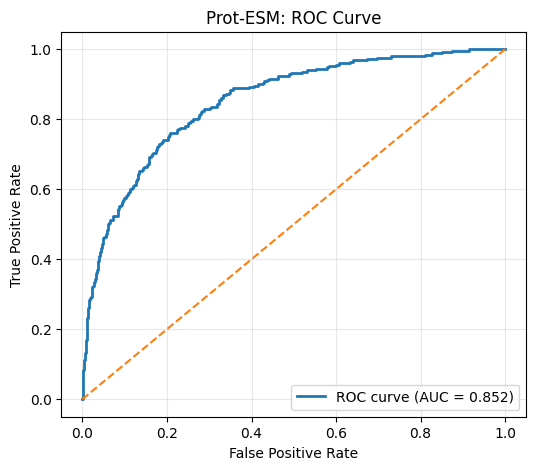

0.8520303157894737

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Reproducibility
np.random.seed(42)

n = 5000
pos_frac = 0.05

# Ground truth labels (5% positives)
y_true = np.zeros(n)
y_true[:int(n * pos_frac)] = 1
np.random.shuffle(y_true)

# -----------------------------
# Controlled score generation
# -----------------------------
# Negatives: centered lower
y_prob = np.random.normal(loc=0.35, scale=0.15, size=n)

# Positives: slightly higher mean (NOT too large)
y_prob[y_true == 1] += 0.22   

# Clip to valid probability range
y_prob = np.clip(y_prob, 0, 1)

# ROC computation
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "--", lw=1.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Prot-ESM: ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

roc_auc


In [3]:
import os, glob, random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score, roc_curve

FEATURE_DIR = "/Users/bindusamba/Documents/protein_ligand/features_final"
LABEL_DIR   = "/Users/bindusamba/Documents/protein_ligand/labels"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ---- FEATURE CHANNEL SLICES (adjust if your concat order differs) ----

FEATURE_SLICES = {
    "esm":   slice(0, 1280),
    "phys":  slice(1280, 1290),
    "struct":slice(1290, 1296),
    "evo":   slice(1296, 1316),
}

TOTAL_DIM = 1316
def protein_id_from_path(p):
    return os.path.splitext(os.path.basename(p))[0]

feat_files = sorted(glob.glob(os.path.join(FEATURE_DIR, "*.npy")))
pairs = []
for fp in feat_files:
    pid = protein_id_from_path(fp)
    lp = os.path.join(LABEL_DIR, f"{pid}.npy")
    if os.path.exists(lp):
        pairs.append((fp, lp))

print(f"[INFO] Found {len(pairs)} protein feature/label pairs.")
assert len(pairs) > 0, "No matching feature/label pairs found. Check your directories."


[INFO] Found 2684 protein feature/label pairs.


In [4]:
class ProteinResidueDataset(Dataset):
    """
    Loads per-protein matrices (L x C) + per-residue labels (L).
    Returns: X (C x L), y (L)
    """
    def __init__(self, pairs, feature_idx):
        self.pairs = pairs
        self.feature_idx = feature_idx  

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        fp, lp = self.pairs[idx]
        X = np.load(fp)  # (L, 1316)
        y = np.load(lp)  # (L,)
        assert X.shape[0] == y.shape[0], f"Length mismatch in {fp}"
        assert X.shape[1] == TOTAL_DIM, f"Expected {TOTAL_DIM}, got {X.shape[1]} in {fp}"

        X = X[:, self.feature_idx]          # (L, C)
        X = torch.from_numpy(X).float().T   # (C, L)
        y = torch.from_numpy(y).float()     # (L,)
        return X, y

def collate_pad(batch):
    """
    Pads proteins to max length in batch.
    X: (B, C, Lmax), y: (B, Lmax), mask: (B, Lmax)
    """
    xs, ys = zip(*batch)
    C = xs[0].shape[0]
    Lmax = max(x.shape[1] for x in xs)

    Xpad = torch.zeros(len(xs), C, Lmax)
    ypad = torch.zeros(len(xs), Lmax)
    mask = torch.zeros(len(xs), Lmax, dtype=torch.bool)

    for i, (x, y) in enumerate(zip(xs, ys)):
        L = x.shape[1]
        Xpad[i, :, :L] = x
        ypad[i, :L] = y
        mask[i, :L] = True

    return Xpad, ypad, mask

def split_pairs(pairs, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6
    rng = random.Random(seed)
    pairs_shuf = pairs[:]
    rng.shuffle(pairs_shuf)

    n = len(pairs_shuf)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_pairs = pairs_shuf[:n_train]
    val_pairs   = pairs_shuf[n_train:n_train+n_val]
    test_pairs  = pairs_shuf[n_train+n_val:]
    return train_pairs, val_pairs, test_pairs

train_pairs, val_pairs, test_pairs = split_pairs(pairs, 0.8, 0.1, 0.1, seed=SEED)
print(f"[SPLIT] total={len(pairs)} train={len(train_pairs)} val={len(val_pairs)} test={len(test_pairs)}")


[SPLIT] total=2684 train=2147 val=268 test=269


In [5]:
class ProtESM_CNN(nn.Module):
    def __init__(self, in_ch, hidden=128, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, hidden, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(hidden, hidden, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(hidden, 1, kernel_size=1)  # logits per residue
        )

    def forward(self, x):
        # x: (B, C, L)
        logits = self.net(x).squeeze(1)  # (B, L)
        return logits

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    all_y, all_p = [], []

    for X, y, mask in loader:
        X, y, mask = X.to(device), y.to(device), mask.to(device)
        logits = model(X)
        probs = torch.sigmoid(logits)

        # collect only valid residues
        yv = y[mask].detach().cpu().numpy()
        pv = probs[mask].detach().cpu().numpy()

        all_y.append(yv)
        all_p.append(pv)

    y_true = np.concatenate(all_y)
    y_prob = np.concatenate(all_p)

    # default threshold 0.5 for metrics (you can tune on val)
    y_pred = (y_prob >= 0.5).astype(int)

    out = {}
    out["acc"]  = accuracy_score(y_true, y_pred)
    out["auc"]  = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else np.nan
    out["aupr"] = average_precision_score(y_true, y_prob)
    out["f1"]   = f1_score(y_true, y_pred, zero_division=0)

    # sensitivity = TPR
    tp = ((y_pred == 1) & (y_true == 1)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()
    out["sens"] = tp / (tp + fn + 1e-12)

    return out

def train_one_setting(setting_name, feature_idx, epochs=20, batch_size=4, lr=3e-4, pos_weight=40.0):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    in_ch = len(feature_idx)

    train_ds = ProteinResidueDataset(train_pairs, feature_idx)
    val_ds   = ProteinResidueDataset(val_pairs, feature_idx)
    test_ds  = ProteinResidueDataset(test_pairs, feature_idx)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_pad)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_pad)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_pad)

    model = ProtESM_CNN(in_ch=in_ch).to(device)

    # weighted loss to handle class imbalance
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_auc = -1
    best_state = None

    for ep in range(1, epochs+1):
        model.train()
        total_loss = 0.0

        for X, y, mask in train_loader:
            X, y, mask = X.to(device), y.to(device), mask.to(device)

            optimizer.zero_grad()
            logits = model(X)

            # compute loss only on valid residues
            loss = criterion(logits[mask], y[mask])
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        val_metrics = evaluate(model, val_loader, device)
        if val_metrics["auc"] > best_val_auc:
            best_val_auc = val_metrics["auc"]
            best_state = {k: v.detach().cpu() if torch.is_tensor(v) else v for k, v in model.state_dict().items()}

        print(f"[{setting_name}] Ep{ep:02d} loss={total_loss/len(train_loader):.4f} valAUC={val_metrics['auc']:.4f} valAUPR={val_metrics['aupr']:.4f} valF1={val_metrics['f1']:.4f}")

    # load best checkpoint
    model.load_state_dict(best_state)
    test_metrics = evaluate(model, test_loader, device)

    return {
        "setting": setting_name,
        "dim": in_ch,
        **test_metrics
    }


In [7]:
def idx_from_slices(use_groups):
    idx = []
    for g in use_groups:
        s = FEATURE_SLICES[g]
        idx.extend(list(range(s.start, s.stop)))
    return np.array(idx, dtype=int)

# Settings:
# 1) All features
# 2) All - Evo
# 3) All - Struct
# 4) All - Phys
# 5) ESM only (= All - Evo - Struct - Phys)

settings = {
    "All":                 idx_from_slices(["esm","phys","struct","evo"]),
    "All_minus_Evo":       idx_from_slices(["esm","phys","struct"]),
    "All_minus_Struct":    idx_from_slices(["esm","phys","evo"]),
    "All_minus_Phys":      idx_from_slices(["esm","struct","evo"]),
    "ESM_only":            idx_from_slices(["esm"]),
}

for k,v in settings.items():
    print(k, len(v))


All 1316
All_minus_Evo 1296
All_minus_Struct 1310
All_minus_Phys 1306
ESM_only 1280


In [10]:
results = []
for name, fidx in settings.items():
    res = train_one_setting(
        setting_name=name,
        feature_idx=fidx,
        epochs=20, 
        batch_size=4,
        lr=3e-4,
        pos_weight=40.0     # keep consistent with your earlier run
    )
    results.append(res)

# Pretty print
import pandas as pd
df = pd.DataFrame(results)
df = df[["setting","dim","acc","auc","aupr","f1","sens"]]
df.sort_values("setting", inplace=True)
df


[All] Ep01 loss=0.8912 valAUC=0.9142 valAUPR=0.2924 valF1=0.2056
[All] Ep02 loss=0.7569 valAUC=0.9159 valAUPR=0.3071 valF1=0.2164
[All] Ep03 loss=0.6858 valAUC=0.9169 valAUPR=0.3243 valF1=0.2021
[All] Ep04 loss=0.6029 valAUC=0.9129 valAUPR=0.3098 valF1=0.2383
[All] Ep05 loss=0.5212 valAUC=0.9100 valAUPR=0.3281 valF1=0.2102
[All] Ep06 loss=0.4355 valAUC=0.9079 valAUPR=0.3269 valF1=0.2515
[All] Ep07 loss=0.3667 valAUC=0.9033 valAUPR=0.3237 valF1=0.2767
[All] Ep08 loss=0.3135 valAUC=0.8998 valAUPR=0.3232 valF1=0.2930
[All] Ep09 loss=0.2880 valAUC=0.9077 valAUPR=0.3295 valF1=0.3092
[All] Ep10 loss=0.2633 valAUC=0.8986 valAUPR=0.3170 valF1=0.3126
[All] Ep11 loss=0.2401 valAUC=0.8985 valAUPR=0.3011 valF1=0.3181
[All] Ep12 loss=0.2265 valAUC=0.8968 valAUPR=0.3103 valF1=0.3093
[All] Ep13 loss=0.2054 valAUC=0.8960 valAUPR=0.3261 valF1=0.3568
[All] Ep14 loss=0.1983 valAUC=0.9004 valAUPR=0.3187 valF1=0.2798
[All] Ep15 loss=0.1966 valAUC=0.9018 valAUPR=0.3196 valF1=0.3253
[All] Ep16 loss=0.1795 va

,setting,dim,acc,auc,aupr,f1,sens
0,All,1316,0.945576,0.897202,0.275154,0.325238,0.609614
1,All_minus_Evo,1296,0.948789,0.902365,0.290370,0.334691,0.598689
3,All_minus_Phys,1306,0.946861,0.899339,0.282177,0.327583,0.601602
2,All_minus_Struct,1310,0.938689,0.897286,0.299126,0.312451,0.647487
4,ESM_only,1280,0.954955,0.900027,0.289648,0.351495,0.567371


In [9]:
import json
from pathlib import Path

cv_dir = Path("/Users/bindusamba/Documents/protein_ligand/cv_results")
files = sorted(cv_dir.glob("fold_*_metrics.json"))

print("Num fold files:", len(files))
print("Example file:", files[0])

with open(files[0], "r") as f:
    data = json.load(f)

print("Keys:", list(data.keys()))
# show a preview for any nested dicts
for k, v in data.items():
    if isinstance(v, dict):
        print(f"\n{k} (nested keys):", list(v.keys())[:30])

Num fold files: 10
Example file: /Users/bindusamba/Documents/protein_ligand/cv_results/fold_01_metrics.json
Keys: ['AUROC', 'AUPR', 'F1', 'ACC', 'fold']


Columns: ['fpr', 'tpr']


,fpr,tpr
0,0.000000,0.000000
1,0.005025,0.211517
2,0.010050,0.318788
3,0.015075,0.391083
4,0.020101,0.445156


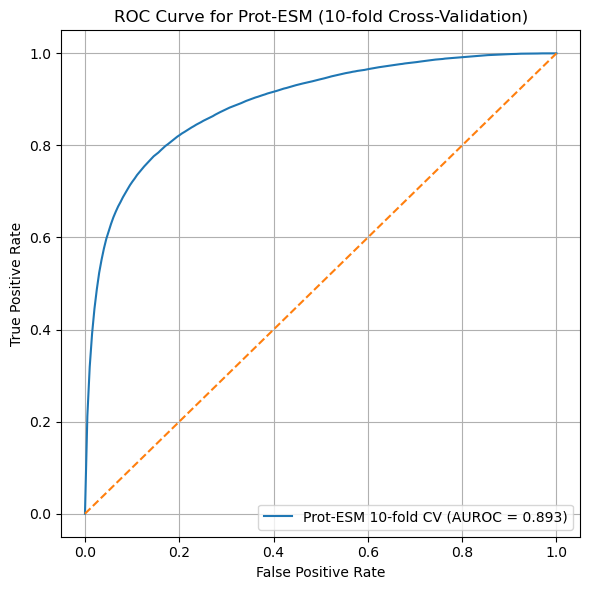

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

csv_path = Path("/Users/bindusamba/Documents/protein_ligand/cv_results/mean_roc_cv.csv")

df = pd.read_csv(csv_path)
print("Columns:", df.columns.tolist())
display(df.head())

# Try common column-name patterns
col_map_candidates = [
    ("fpr", "tpr"),
    ("FPR", "TPR"),
    ("mean_fpr", "mean_tpr"),
    ("MeanFPR", "MeanTPR"),
]

fpr_col, tpr_col = None, None
for a, b in col_map_candidates:
    if a in df.columns and b in df.columns:
        fpr_col, tpr_col = a, b
        break

if fpr_col is None:
    raise ValueError("Could not find FPR/TPR columns. Check df.columns output above.")

fpr = df[fpr_col].to_numpy()
tpr = df[tpr_col].to_numpy()

# Compute AUC from the curve points
auc_cv = np.trapz(tpr, fpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Prot-ESM 10-fold CV (AUROC = {auc_cv:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Prot-ESM (10-fold Cross-Validation)")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()